In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import itertools
import torch
import os

import scipy.stats

import tsvar
from tsvar.preprocessing import Dataset
import experiments_utils

Set cells width

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

---

## Load the dataset

Set input path

In [5]:
INPUT_PATH = "../../data/CollegeForum/dataset-collegeForum.pk"

Load the dataset

In [11]:
dataset = Dataset.from_pickle(INPUT_PATH)

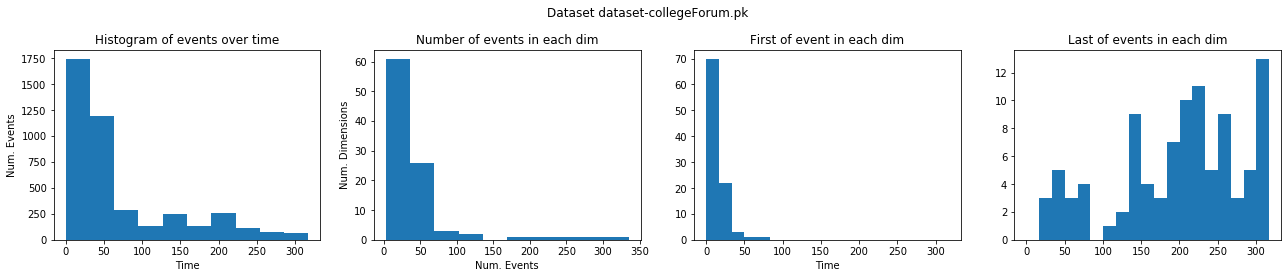

In [12]:
fig, axs = plt.subplots(1, 4, figsize=(22, 3.5))

axs[0].hist(np.hstack(dataset.timestamps))
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Num. Events')
axs[0].set_title('Histogram of events over time')

axs[1].hist(list(map(len, dataset.timestamps)))
axs[1].set_xlabel('Num. Events')
axs[1].set_ylabel('Num. Dimensions')
axs[1].set_title('Number of events in each dim')


end_time = max(map(max, dataset.timestamps))
axs[2].hist(list(map(min, dataset.timestamps)), bins=np.linspace(0, end_time, 20))
axs[2].set_title('First of event in each dim')
axs[2].set_xlabel('Time')

axs[3].hist(list(map(max, dataset.timestamps)), bins=np.linspace(0, end_time, 20))
axs[3].set_title('Last of events in each dim')
axs[2].set_xlabel('Time')

fig.suptitle(f"Dataset {os.path.split(INPUT_PATH)[1]}", y=1.05);

Print statistics of the dataset

In [13]:
print(f"Num. of dimensions: {len(dataset.timestamps):,d}")
print(f"    Num. of events: {sum(map(len, dataset.timestamps)):,d}")
print(f"               %NZ: {100 * dataset.graph.number_of_edges() / (dataset.graph.number_of_nodes() ** 2):.2f}%")
print()
print("Stats. of num. of events per dim:")
num_jumps_per_dim = np.array(list(map(len, dataset.timestamps)))
print(pd.Series(num_jumps_per_dim).describe())

Num. of dimensions: 97
    Num. of events: 4,254
               %NZ: 5.44%

Stats. of num. of events per dim:
count     97.000000
mean      43.855670
std       55.632161
min        3.000000
25%       17.000000
50%       29.000000
75%       47.000000
max      335.000000
dtype: float64


In [14]:
min_time = min(map(min, dataset.timestamps))
dataset.timestamps = [ev - min_time for ev in dataset.timestamps]

#### Visualize the scale of time using empirical inter-arrival time distributions

Compute this for both definitions $\{\beta_j\}$ and $\{\beta_{ij}\}$.

Busca estimators of **beta_j**:
count    97.000000
mean      3.673958
std       8.926176
min       0.054121
25%       0.692930
50%       1.507842
75%       2.840387
max      67.277632
dtype: float64

Busca estimators of **beta_{ji}**:
count    9409.000000
mean        2.863596
std         6.697033
min         0.000000
25%         0.337757
50%         0.934355
75%         2.365677
max        78.644760
dtype: float64



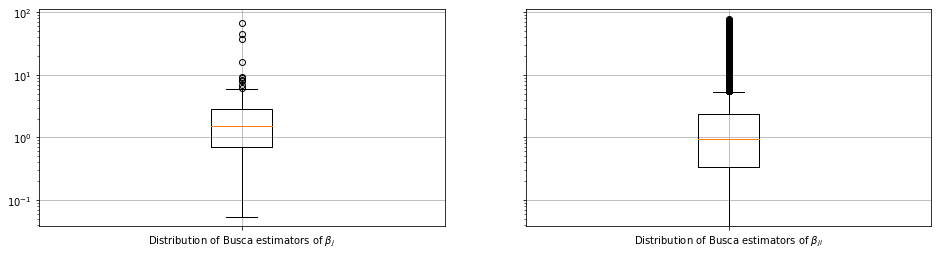

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4), sharey=True)

busca_betas = np.array([np.median(np.hstack((ev[0], np.diff(ev)))) for ev in dataset.timestamps])
plt.sca(axs[0])
plt.grid()
plt.boxplot(busca_betas, labels=[r'Distribution of Busca estimators of $\beta_j$']);
plt.yscale('log')
print('Busca estimators of **beta_j**:')
print(pd.Series(busca_betas.flatten()).describe())
print()

wold_model = tsvar.models.WoldModel()
wold_model.observe(dataset.timestamps)
busca_beta_ji = np.zeros((wold_model.dim, wold_model.dim))
for i in range(wold_model.dim):
    busca_beta_ji[:, i] = np.median(wold_model.delta_ikj[i][:, :], axis=0) / np.exp(1)
del wold_model
plt.sca(axs[1])
plt.grid()
plt.boxplot(busca_beta_ji.flatten(), labels=[r'Distribution of Busca estimators of $\beta_{ji}$']);
plt.yscale('log')
print('Busca estimators of **beta_{ji}**:')
print(pd.Series(busca_beta_ji.flatten()).describe())
print()

Build ground truth adjacency matrix

In [16]:
adjacency_true = nx.adjacency_matrix(dataset.graph, nodelist=range(dataset.dim)).toarray()
adjacency_true = adjacency_true / adjacency_true.max()

In [17]:
events = dataset.timestamps
end_time = dataset.end_time

---

## Run inference

---

### Run BBVI

In [ ]:
dim = len(events)
n_params = dim + dim**2 + dim**2
end_time = max(map(max, events))

# Set initial guess
coeffs_start = torch.tensor(np.hstack((
    # loc
    -2.0 * torch.ones(dim, dtype=torch.float),                   # baseline
    -2.0 * torch.ones((dim, dim), dtype=torch.float).flatten(),  # beta
     0.0 * torch.ones((dim, dim), dtype=torch.float).flatten(),  # adjacency
    # scale
    torch.log(0.2 * torch.ones(dim, dtype=torch.float)),
    torch.log(1.0 * torch.ones((dim, dim), dtype=torch.float).flatten()),
    torch.log(1.0 * torch.ones((dim, dim), dtype=torch.float).flatten()),
)))

# Define priors/posteriors
posterior = tsvar.posteriors.LogNormalPosterior
prior = tsvar.priors.GaussianLaplacianPrior
mask_gaus = torch.zeros(n_params, dtype=torch.bool)
mask_gaus[:dim + dim**2] = 1  # Gaussian prior for baseline and beta
C = 1e2

# Init the model object
model = tsvar.models.WoldModelBBVI(posterior=posterior, prior=prior, C=C,
                                   prior_kwargs={'mask_gaus': mask_gaus},
                                   n_samples=1, n_weights=1, weight_temp=1,
                                   verbose=False, device='cpu')
model.observe(events, end_time)

# Set link function for callback (vi coeffs -> posterior mode)
def link_func(coeffs):
    """variationa coeffs -> posterior mode of adjacency"""
    # Numpy to torch
    coeffs = torch.tensor(coeffs) if isinstance(coeffs, np.ndarray) else coeffs
    params_mode = model.posterior.mode(
        coeffs[:model.n_params], coeffs[model.n_params:]
    ).detach().numpy()
    beta_mode = params_mode[dim:-dim**2]
    adj_mode = params_mode[-dim**2:]
    return adj_mode / beta_mode


class MyCallback(tsvar.utils.callbacks.LearnerCallbackMLE):
    
    def __call__(self, learner_obj, end=None, force=False):
        super().__call__(learner_obj, end, force)
        t = learner_obj._n_iter_done + 1
        if (t % self.print_every == 0) or force:
            coeffs_hat = model.posterior.mode(model.coeffs[:n_params], model.coeffs[n_params:]).detach().numpy()
            mu_hat = coeffs_hat[:dim]
            beta_hat = coeffs_hat[dim:dim+dim**2]
            adj_hat = coeffs_hat[dim+dim**2:]
            print(f'   mu --> min: {mu_hat.min():.2e}, median: {np.median(mu_hat):.2e}, max: {mu_hat.max():.2e}')
            print(f' beta --> min: {beta_hat.min():.2e}, median: {np.median(beta_hat):.2e}, max: {beta_hat.max():.2e}')
            print(f'  adj --> min: {adj_hat.min():.2e}, median: {np.median(adj_hat):.2e}, max: {adj_hat.max():.2e}', flush=True)

# Set the callback (callback parameters are posterior mode)
callback = MyCallback(
    x0=posterior().mode(
        coeffs_start[:dim+2*dim**2], coeffs_start[dim+2*dim**2:]
    )[dim:dim+dim**2],
    print_every=50,
    coeffs_true=adjacency_true,
    acc_thresh=0.05,
    dim=dim,
    link_func=link_func,
    default_end='\n')


# Fit the model
conv = model.fit(x0=coeffs_start, optimizer=torch.optim.Adam, lr=1e-1,
                 lr_sched=0.9999, tol=1e-6, max_iter=20000,
                 mstep_interval=100, mstep_offset=500, mstep_momentum=0.5,
                 seed=None, callback=callback)

In [ ]:
coeffs_hat = model.posterior.mode(model.coeffs[:n_params], model.coeffs[n_params:]).detach().numpy()
mu_hat = coeffs_hat[:dim]
beta_hat = coeffs_hat[dim:dim+dim**2]
adj_hat = coeffs_hat[dim+dim**2:]

In [ ]:
plt.boxplot([adj_hat.flatten(), beta_hat.flatten()]);
plt.title(f'Method {type(model).__name__}')

In [ ]:
coeffs_hat = model.posterior.mode(model.coeffs[:n_params], model.coeffs[n_params:]).detach().numpy()
beta_hat = coeffs_hat[dim:dim+dim**2]
adj_hat = coeffs_hat[dim+dim**2:]

adj_hat = adj_hat / beta_hat

experiments_utils.print_report(name=type(model).__name__, adj_hat=adj_hat, adj_true=adjacency_true, thresh=0.02)

---

### Run VI

In [18]:
dim = len(events)

# Set priors
# prior: Alpha
as_pr = 0.01 * np.ones((dim + 1, dim))
ar_pr = 1.0 * np.ones((dim + 1, dim))

# prior: Beta
bs_pr = 10.0 * np.ones((dim, dim))
br_pr = 10.0 * np.ones((dim, dim))

# prior: Z
zc_pr = [1.0 * np.ones((len(events[i]), dim+1)) for i in range(dim)]

print('ALPHA:')
print('------')
print('mean')
print(as_pr[0,0] / ar_pr[0,0])
print('variance')
print(as_pr[0,0] / ar_pr[0,0] ** 2)

print('BETA:')
print('-----')
print('mean')
print(br_pr[0,0] / (bs_pr[0,0] - 1))
print('variance')
print(br_pr[0,0]**2 / ((bs_pr[0,0] - 1)**2 * (bs_pr[0,0] - 2)))

ALPHA:
------
mean
0.01
variance
0.01
BETA:
-----
mean
1.1111111111111112
variance
0.15432098765432098


In [19]:
# Set model & observations
vi_model = tsvar.models.WoldModelVariational(verbose=True)
vi_model.observe(events)

In [20]:
# Set callback (parameters of callback are just the posterior mean of alpha)
callback = tsvar.utils.callbacks.LearnerCallbackMLE(
    x0=(as_pr[1:,:] / ar_pr[1:,:]).flatten(), print_every=10,
    coeffs_true=adjacency_true.flatten(),
    acc_thresh=0.05, dim=dim, 
    widgets={'f1score', 'relerr', 'prec@5', 'prec@10', 'prec@20'},
    default_end='\n')

# Fit model
vi_model.fit(as_pr=as_pr, ar_pr=ar_pr, bs_pr=bs_pr, br_pr=br_pr, zc_pr=zc_pr, 
          max_iter=2500, tol=1e-5, callback=callback)

iter:    10 | dx: +3.5831e-01 | f1-score: 0.09 | relerr: 2.03e+00 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 3.12e+00     
iter:    20 | dx: +8.1036e-02 | f1-score: 0.07 | relerr: 2.01e+00 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 2.93e-01     
iter:    30 | dx: +4.8640e-02 | f1-score: 0.05 | relerr: 1.99e+00 | p@5: 0.00 | p@10: 0.20 | p@20: 0.20 | time/it: 2.38e-01     
iter:    40 | dx: +4.9345e-02 | f1-score: 0.05 | relerr: 1.98e+00 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 2.98e-01     
iter:    50 | dx: +4.4919e-02 | f1-score: 0.04 | relerr: 1.97e+00 | p@5: 0.00 | p@10: 0.10 | p@20: 0.20 | time/it: 2.58e-01     
iter:    60 | dx: +5.0004e-02 | f1-score: 0.04 | relerr: 1.97e+00 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 2.48e-01     
iter:    70 | dx: +5.1525e-02 | f1-score: 0.04 | relerr: 1.97e+00 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 2.12e-01     
iter:    80 | dx: +3.4722e-02 | f1-score: 0.04 | relerr: 1.96e+00 | p@5: 0.00 | p@10: 0.10 | p@20

iter:   650 | dx: +3.2392e-05 | f1-score: 0.04 | relerr: 1.96e+00 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 2.36e-01     
iter:   660 | dx: +1.9207e-05 | f1-score: 0.04 | relerr: 1.96e+00 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 2.47e-01     
iter:   670 | dx: +2.3238e-05 | f1-score: 0.04 | relerr: 1.96e+00 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 2.20e-01     
iter:   680 | dx: +1.7036e-05 | f1-score: 0.04 | relerr: 1.96e+00 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 2.07e-01     
iter:   690 | dx: +4.1522e-05 | f1-score: 0.04 | relerr: 1.96e+00 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 2.18e-01     
iter:   700 | dx: +4.3161e-05 | f1-score: 0.04 | relerr: 1.96e+00 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 2.10e-01     
iter:   710 | dx: +2.6267e-05 | f1-score: 0.04 | relerr: 1.96e+00 | p@5: 0.00 | p@10: 0.10 | p@20: 0.15 | time/it: 2.07e-01     
iter:   720 | dx: +2.0196e-05 | f1-score: 0.04 | relerr: 1.96e+00 | p@5: 0.00 | p@10: 0.10 | p@20

KeyboardInterrupt: 

In [22]:
alpha_hat = vi_model._as_po[1:, :] / vi_model._ar_po[1:, :]
beta_hat = vi_model._br_po[:, :] / (vi_model._bs_po[:, :] + 1) + 1

adj_hat = alpha_hat
#adj_hat = alpha_hat / beta_hat

#adj_hat[np.eye(len(adj_hat)).astype(bool)] = 0.0

experiments_utils.print_report(name=type(vi_model).__name__, adj_hat=adj_hat, adj_true=adjacency_true, thresh=0.0001)


========== Method: WoldModelVariational

Accuracy: 0.09

Edge counts
------------
Pred: 9034.00
True: 512.00

Error counts
------------
 True Positive: 496.00
False Positive: 8538.00
 True Negative: 359.00
False Negative: 16.00

Error rates
-----------
 True Positive Rate: 0.97
False Positive Rate: 0.96
 True Negative Rate: 0.04
False Negative Rate: 0.03

F-Score
-------
 F1-Score: 0.10
Precision: 0.05
   Recall: 0.97

Precision@k
-----------
  Prec@5: 0.00
 Prec@10: 0.10
 Prec@20: 0.15
 Prec@50: 0.12
Prec@100: 0.10
Prec@200: 0.07

Average Precision@k per node
----------------------------
AvgPrec@k per node:
5 0.013953488372093023
10 0.01976744186046512
20 0.04883720930232553
50 0.05418604651162789
100 0.05953488372093016
200 0.02976744186046508



In [ ]:
plt.boxplot(adj_hat.flatten());
plt.yscale('log');

In [ ]:
plt.figure(figsize=(10, 5))
plt.grid()
plt.boxplot(
    [adj_hat[adjacency_true == 0.0], adj_hat[adjacency_true > 0.0]],
    labels=['True Non-edges', 'True Edges'])
plt.ylabel(r'Learned value of paramaters')
plt.title('Distribution of learned adjacency weights');

In [ ]:
plt.boxplot([adj_hat.flatten(), beta_hat.flatten()], labels=['Alphas', 'Betas']);

---

### Run GB

In [29]:
import gb
import time

dim = len(events)

# Define model
granger_model = gb.GrangerBusca(
    alpha_prior=1.0/len(events),
    num_iter=30000,
    metropolis=True,
    beta_strategy='busca',
    num_jobs=4,
)
granger_model.fit(events)

In [30]:
# Extract infered adjacency
adj_hat = granger_model.Alpha_.toarray()
adj_hat = adj_hat / adj_hat.sum(axis=1)[:, None]
beta_hat = np.ones((dim, dim)) * (granger_model.beta_ + 1)
coeffs_hat = np.hstack((granger_model.mu_, beta_hat.flatten(),
                        adj_hat.flatten()))

adj_hat = adj_hat / beta_hat  # Does not matter


THRESH = 0.00  # GB is already sparse

experiments_utils.print_report(name=type(granger_model).__name__, adj_hat=adj_hat, adj_true=adjacency_true, thresh=0)


========== Method: GrangerBusca

Accuracy: 0.05

Edge counts
------------
Pred: 369.00
True: 512.00

Error counts
------------
 True Positive: 30.00
False Positive: 339.00
 True Negative: 8558.00
False Negative: 482.00

Error rates
-----------
 True Positive Rate: 0.06
False Positive Rate: 0.04
 True Negative Rate: 0.96
False Negative Rate: 0.94

F-Score
-------
 F1-Score: 0.07
Precision: 0.08
   Recall: 0.06

Precision@k
-----------
  Prec@5: 0.20
 Prec@10: 0.30
 Prec@20: 0.25
 Prec@50: 0.14
Prec@100: 0.12
Prec@200: 0.09

Average Precision@k per node
----------------------------
AvgPrec@k per node:
5 0.36279069767441835
10 0.23488372093023246
20 0.12558139534883722
50 0.05069767441860464
100 0.02534883720930232
200 0.01267441860465116



In [ ]:
tsvar.utils.metrics.relerr(adj_hat.flatten(), adjacency_true.flatten(), null_norm='none')

In [ ]:
scipy.stats.kendalltau(adj_hat.flatten(), adjacency_true.flatten())

In [ ]:
tsvar.utils.metrics.mean_kendall_rank_corr(adj_hat.flatten(), adjacency_true.flatten())

In [ ]:
plt.scatter(adj_hat.flatten(), adjacency_true.flatten())

In [ ]:
mean_rank_corr, rank_corr_per_dim = tsvar.utils.metrics.mean_kendall_rank_corr(
    adj_hat.flatten(), adjacency_true.flatten(), return_vec=True)

In [ ]:
mean_rank_corr

In [ ]:
plt.hist(rank_corr_per_dim)

In [ ]:
from scipy.stats import kendalltau

# calculate kendall's correlation
coef, p = kendalltau(
    x=adj_hat.flatten(),
    y=adjacency_true.flatten()
)

print('Kendall correlation coefficient: %.3f' % coef)
# interpret the significance
alpha = 0.05
if p > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
else:
    print('Samples are correlated (reject H0) p=%.3f' % p)

---

## Exploration of results

In [ ]:
adj_hat = vifb_model._as_po[1:, :] / vifb_model._ar_po[1:, :]
adj_hat

In [ ]:
adj_hat.nonzero()

In [ ]:
adj_hat = vifb_model._as_po[1:, :] / vifb_model._ar_po[1:, :]

thresh_list = np.linspace(0.01, 0.15, 20)

vals_vifb = {
    5: np.zeros_like(thresh_list),
    10: np.zeros_like(thresh_list),
    20: np.zeros_like(thresh_list),
}

for i, thresh in enumerate(thresh_list):

    adj_hat_thresh = adj_hat.copy()
    adj_hat_thresh[adj_hat_thresh < thresh] = 0.0
    print(np.round(thresh, 3), len(adj_hat_thresh.nonzero()[0]))

    for k in [5, 10, 20]:
        vals_vifb[k][i] = tsvar.utils.metrics.precision_at_n_per_dim(A_pred=adj_hat_thresh, A_true=adjacency_true, k=k)

In [ ]:
thresh_list = np.linspace(0.01, 0.15, 20)

vals_gb = {
    5: np.zeros_like(thresh_list),
    10: np.zeros_like(thresh_list),
    20: np.zeros_like(thresh_list),
}

for i, thresh in enumerate(thresh_list):

    adj_hat_thresh = adj_hat.copy()
    adj_hat_thresh[adj_hat_thresh < thresh] = 0.0

    for k in [5, 10, 20]:
        vals_gb[k][i] = tsvar.utils.metrics.precision_at_n_per_dim(A_pred=adj_hat_thresh, A_true=adjacency_true, k=k)

In [ ]:
plt.figure(figsize=(12, 6))
plt.grid()

plt.plot(thresh_list, vals_vifb[5], label='p@5')
plt.plot(thresh_list, vals_vifb[10], label='p@10')
plt.plot(thresh_list, vals_vifb[20], label='p@20')

plt.plot(thresh_list, vals_gb[5],   label='p@5', c='C0', ls='--')
plt.plot(thresh_list, vals_gb[10], label='p@10', c='C1', ls='--')
plt.plot(thresh_list, vals_gb[20], label='p@20', c='C2', ls='--')

plt.legend();